In [ ]:
import os, glob, sqlite3, math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def _find_db3(bag_dir):
    files = sorted(glob.glob(os.path.join(bag_dir, "*.db3")))
    if not files: raise FileNotFoundError(f"No .db3 in {bag_dir}")
    return files[0]

def _load_topics(db3_path):
    with sqlite3.connect(db3_path) as con:
        cur = con.cursor()
        rows = cur.execute("SELECT id, name FROM topics").fetchall()
    id2name = {rid: name for rid, name in rows}
    name2id = {name: rid for rid, name in rows}
    return id2name, name2id

def _load_timestamps(db3_path, topic_ids):
    ts_map = {tid: [] for tid in topic_ids}
    with sqlite3.connect(db3_path) as con:
        cur = con.cursor()
        for tid in topic_ids:
            cur.execute("SELECT timestamp FROM messages WHERE topic_id=? ORDER BY timestamp", (tid,))
            ts = [r[0] for r in cur.fetchall()]
            ts_map[tid] = np.asarray(ts, dtype=np.int64)
    return ts_map

def _ema(y, alpha):
    if y.size == 0: return y
    out = np.empty_like(y, dtype=np.float64)
    out[0] = y[0]
    for i in range(1, y.size):
        out[i] = alpha * y[i] + (1.0 - alpha) * out[i-1]
    return out

def _rates(ts_ns, win_s):
    if ts_ns.size == 0: return np.array([]), np.array([])
    t = (ts_ns - ts_ns.min()) * 1e-9
    if np.ptp(t) == 0:
        edges = np.array([0.0, max(win_s, 1e-3)])
    else:
        nb = int(math.ceil(t.max() / win_s))
        edges = np.linspace(0.0, nb*win_s, nb+1)
    cnts, edges = np.histogram(t, bins=edges)
    centers = 0.5*(edges[:-1] + edges[1:])
    return centers, cnts / win_s

def _gaps(ts_ns):
    if ts_ns.size < 2: return np.array([]), np.array([])
    t_rel = (ts_ns - ts_ns.min()) * 1e-9
    dt = np.diff(ts_ns) * 1e-9
    x = t_rel[1:]  # gap aligned to later msg
    return x, dt

def plot_topic_rate_and_dt(bag_dir, topics=None, win_s=1.0, smooth=0.0, smooth_rate=0.0,
                           show_median_dt=True, out_path=None, dpi=130):
    db3 = _find_db3(bag_dir)
    id2name, name2id = _load_topics(db3)
    sel = list(name2id.keys()) if not topics else topics
    sel_ids = [name2id[t] for t in sel if t in name2id]
    ts_map = _load_timestamps(db3, sel_ids)

    n = len(sel_ids)
    fig, axes = plt.subplots(n, 1, figsize=(14, 2 + 1.8*n), sharex=True)
    axes = [axes] if n == 1 else axes

    alpha_dt   = max(1e-4, 1.0 - float(smooth))
    alpha_rate = max(1e-4, 1.0 - float(smooth_rate))

    for ax, tid in zip(axes, sel_ids):
        ts_ns = ts_map[tid]
        name = id2name[tid]
        rate_x, rate_y = _rates(ts_ns, win_s)
        if smooth_rate > 0 and rate_y.size:
            rate_y = _ema(rate_y, alpha_rate)

        dt_x, dt_y = _gaps(ts_ns)
        dt_plot = _ema(dt_y, alpha_dt) if (smooth > 0 and dt_y.size) else dt_y

        ax_rate = ax
        ax_dt = ax_rate.twinx()

        if rate_x.size:
            ax_rate.plot(rate_x, rate_y, linewidth=1.2, c='r', label="rate (Hz)")
            zero_mask = rate_y == 0
            if np.any(zero_mask):
                ax_rate.scatter(rate_x[zero_mask], rate_y[zero_mask], marker='x')

        if dt_x.size:
            ax_dt.plot(dt_x, dt_plot, linewidth=1.0, linestyle='--', label="Δt (s)")
            if show_median_dt:
                med = float(np.median(dt_y))
                ax_dt.axhline(med, linestyle=':', linewidth=0.9)

        # ---- Mean and Std of Δt ----
        if dt_y.size:
            mean_dt = np.mean(dt_y)
            std_dt = np.std(dt_y)
            ax_rate.set_title(
                f"{name}\nmean Δt = {mean_dt:.4f} s | std = {std_dt:.4f} s",
                fontsize=10
            )
        else:
            ax_rate.set_title(f"{name}\n(no Δt data)", fontsize=10)
            
        ax_rate.set_ylim(bottom=0)
        ax_dt.set_ylim(bottom=0)
        ax_rate.set_ylabel("Hz")
        ax_dt.set_ylabel("Δt (s)")
        ax_rate.grid(True, alpha=0.3)

    axes[-1].set_xlabel(f"Time since first msg (s)  |  rate window={win_s:.2f}s")
    fig.suptitle("Topic Rate and Inter-message Δt", y=0.995)
    plt.tight_layout()
    if out_path:
        plt.savefig(out_path, dpi=dpi, bbox_inches='tight')
        print(f"Saved: {out_path}")
    else:
        plt.show()

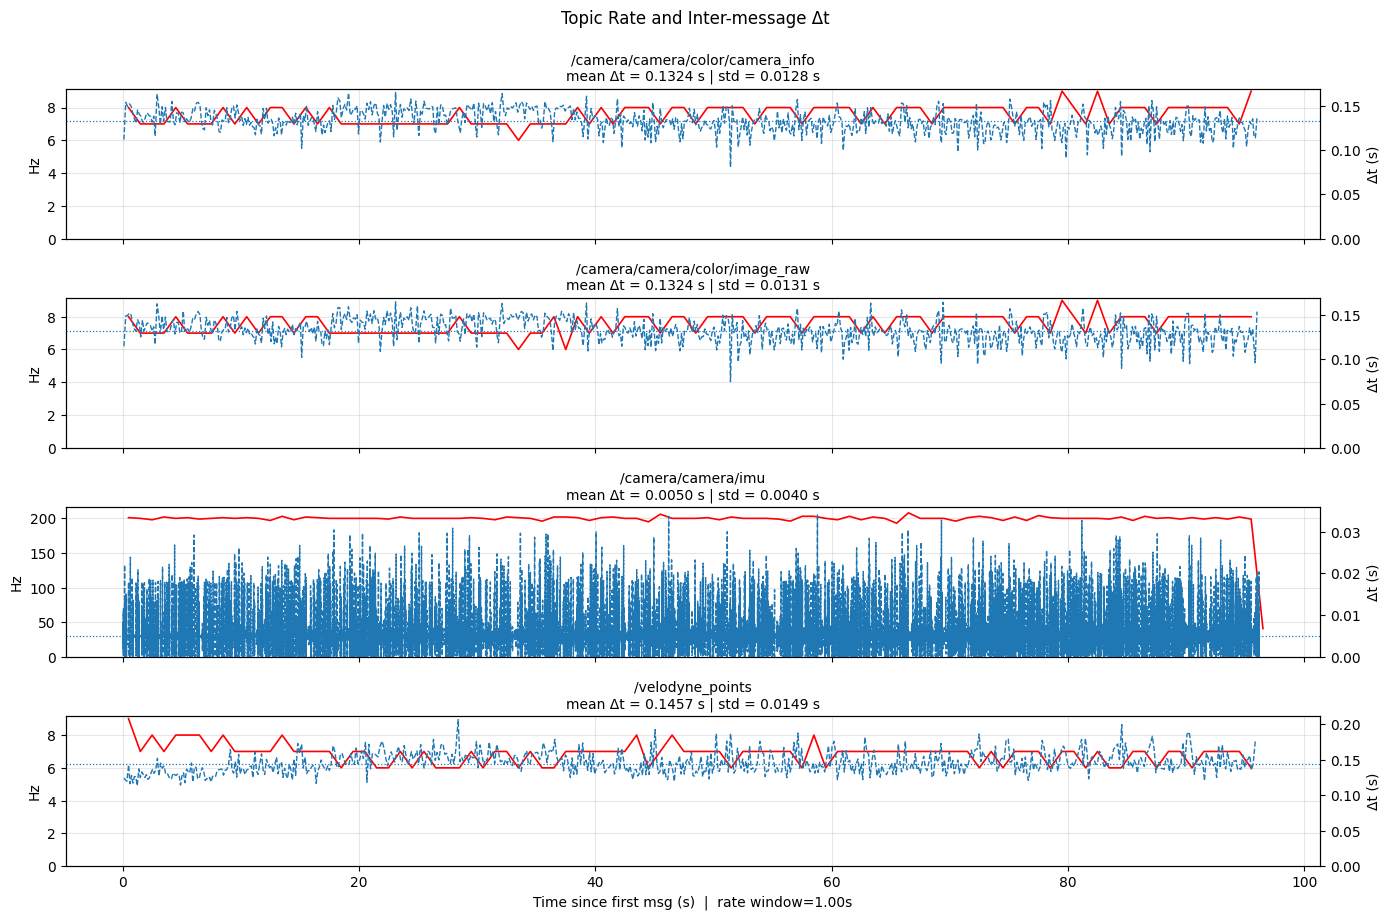

In [5]:
plot_topic_rate_and_dt(
    "/home/vorart/workspace/robotics/Hermes/data/yolo_640",
    win_s=1,
    smooth=0.0,        # smooth Δt
    smooth_rate=0.0    # optional smoothing for rate
)

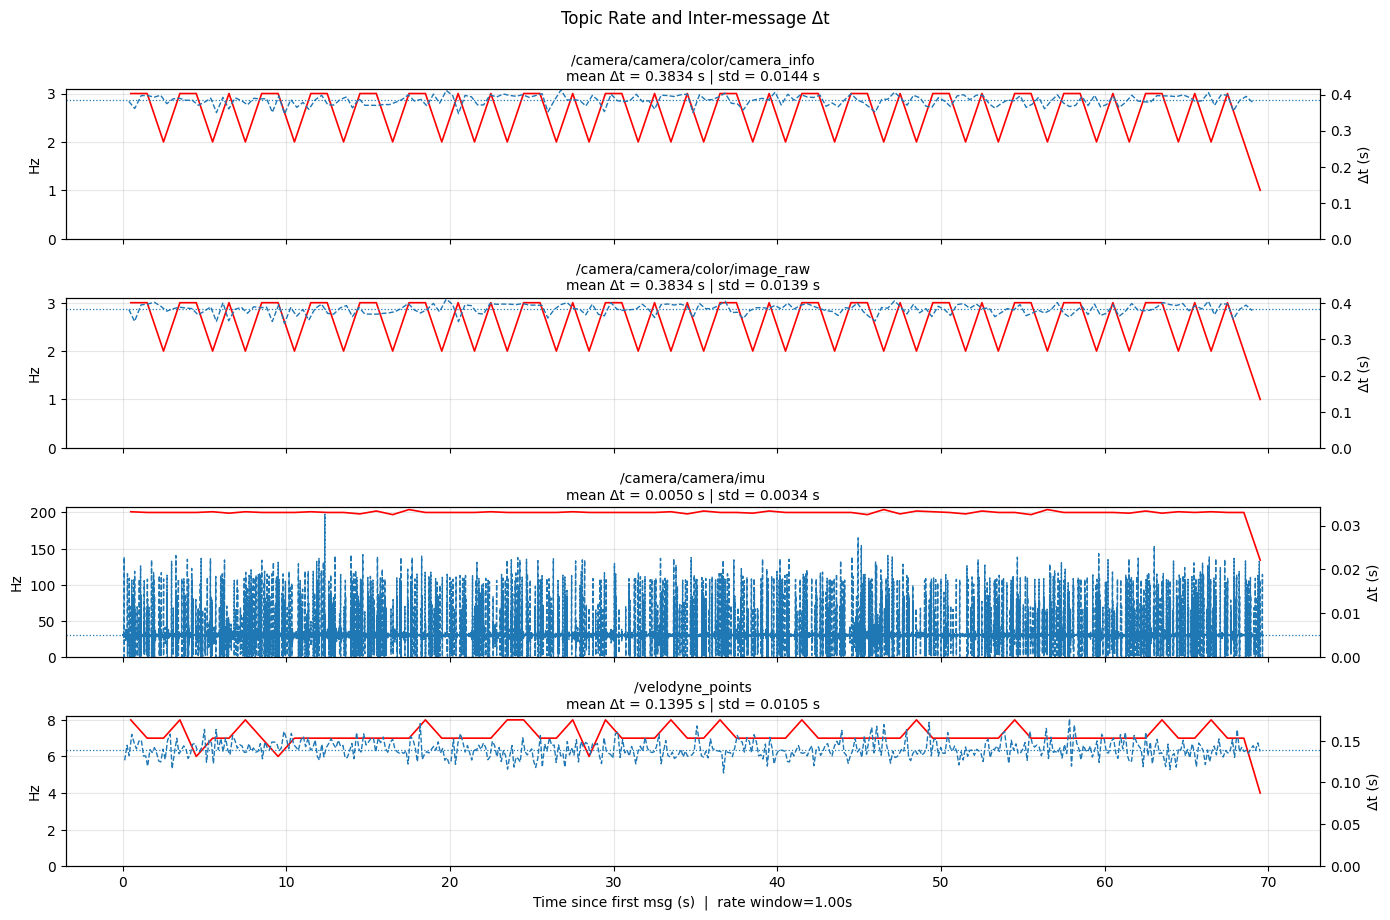

In [4]:
plot_topic_rate_and_dt(
    "/home/vorart/workspace/robotics/Hermes/data/yolo",
    win_s=1,
    smooth=0.0,        # smooth Δt
    smooth_rate=0.0    # optional smoothing for rate
)